# Glassdoor data

- In which industries is there a high demand for data science?
- Which are the essentials skills for DS? How we can upskill our consultants?

### Data preprocessing steps:
1. Clean text
   - Parse words
   - Remove all special characters
   - Cleaned formatting
2. Tokenize
   - Words
   - Sentences
3. Counts
   - Word Count w/ visualization
   - Sentence Count w/ visualization
4. Stop Word Removal
5. Stemming (**technique used to extract the base form of the words by removing affixes from them**. It is just like cutting down the branches of a tree to its stems)
6. Lemmatization (**grouping together of different forms of the same word**)
7. create one large corpus for analysis


### TODO 
Issue with duplicated job postings 

In [1]:
import pandas as pd
import itertools
import matplotlib
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
# import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings
import sys

warnings.filterwarnings("ignore")

# sns.set()
# # used for better images in medium article
font = {"family" : "Times New Roman",
        "weight" : "bold",
        "size"   : 22}

matplotlib.rc("font", **font)

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from fuzzywuzzy import fuzz#

# In order to create tokens you need to run "downloader module".
# This module defines several interfaces which can be used to download corpora, models, and
# other data packages that can be used with NLTK.

# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

## Load data

In [3]:
data= pd.read_csv("../output/glassdoor_scraping/listings_scraped_raw_16-11-2022.csv",encoding_errors= "replace")

In [5]:
data= pd.read_csv("../output/glassdoor_scraping/listings_scraped_raw_16-11-2022.csv",encoding_errors= "replace")
print(data.columns)

print(f"Table size: {data.shape}")

#data  = data[["companyName", "company_offeredRole","Contract",
#              "industry", "industry_type", "listing_jobDesc"]]

data = data.drop_duplicates()
print(f"Drop duplicated job postings, Table size: {data.shape}")
print(data.isnull().sum()/len(data))

data = data[~data.listing_desc.isna()]
print(f"Remove missing JD, Table size: {data.shape}")

data.head(1)

Index(['company_name', 'company_star_rating', 'role_title', 'role_location',
       'industry', 'company_type', 'listing_desc', 'listing_url', 'page_url',
       'page_num'],
      dtype='object')
Table size: (19, 10)
Drop duplicated job postings, Table size: (19, 10)
company_name           0.000000
company_star_rating    0.052632
role_title             0.000000
role_location          0.000000
industry               0.000000
company_type           0.210526
listing_desc           0.000000
listing_url            0.000000
page_url               0.000000
page_num               0.000000
dtype: float64
Remove missing JD, Table size: (19, 10)


,company_name,company_star_rating,role_title,role_location,industry,company_type,listing_desc,listing_url,page_url,page_num
0,IQVIA CSMS,4.0,Data Analytics Analyst,"London, England",Company - Public (IQV),Biotech & Pharmaceuticals,\r\nResponsible for quality assuring outputs a...,www.glassdoor.com/partner/jobListing.htm?pos=1...,https://www.glassdoor.com/Job/london-data-scie...,1


#### Functions 

In [6]:
# add the path to system variables
sys.path.insert(1, '../text_cleaning/')

from nlp import clean_text, remove_punctuation, remove_non_ascii, stopword_removal, stemming, lemming, get_top_n_words, get_top_n2_words, get_top_n3_words, search_skills, replace_all

### NLP clean text



In [8]:
## clean text
data["listing_jobDesc_clean"] = data.listing_desc.apply(clean_text)

## to lower cases

data.listing_jobDesc_clean = data.listing_jobDesc_clean.str.lower()

## replace based on dictionary 
dictionary = {"r":"r_code",
            "machine learning":"machine_learning",
            "power bi":"power_bi",
            "github":"git", "gitlab":"git", "version":"git",
            "ci":"ci_tools",
            "db":"database",
            "ai":"artificial_intelligence",
            "computer vision":"computer_vision",
            "a/b":"ab_testing",
            "big data": "big_data",
            "mining": "data_mining",
            "data science":"data_science"
            }  # create a dictionary of words-to-replace and words-to-replace-with

data.listing_jobDesc_clean = data.listing_jobDesc_clean.apply(replace_all,dic=dictionary)

## tokens 

tokenizer = RegexpTokenizer(r"\w+")
data["word_tokenized"] = data.listing_jobDesc_clean.apply(lambda row: tokenizer.tokenize(row))


data["word_tokenized"] = data.word_tokenized.apply(lambda row: remove_punctuation(row))

data["word_tokenized"] = data.word_tokenized.apply(lambda row: remove_non_ascii(row))


## sentences 

data["sentence_tokenized"] = data.listing_jobDesc_clean.apply(lambda row: sent_tokenize(row))


## Stop words removal

In [9]:
data["clean_words"] = data.word_tokenized.apply(stopword_removal)
data.head(1)


,company_name,company_star_rating,role_title,role_location,industry,company_type,listing_desc,listing_url,page_url,page_num,listing_jobDesc_clean,word_tokenized,sentence_tokenized,clean_words
0,IQVIA CSMS,4.0,Data Analytics Analyst,"London, England",Company - Public (IQV),Biotech & Pharmaceuticals,\r\nResponsible for quality assuring outputs a...,www.glassdoor.com/partner/jobListing.htm?pos=1...,https://www.glassdoor.com/Job/london-data-scie...,1,responsible for quality assuring outputs and i...,"[responsible, for, quality, assuring, outputs,...",[responsible for quality assuring outputs and ...,"[responsible, quality, assuring, outputs, issu..."


In [10]:
### filter for contracts 
# data = data[data.Contract==True]

## Fuzzy matching (input `clean_words` and skills.txt)

In [11]:
similarity_threshold = 85

In [12]:
#TODO review this approach
# Perform fuzzy string matching for each posting
# skills_txt = pd.read_csv("input_data/skills.txt")
# skills_list = skills_txt["Skill"].map(lambda x: x.lower()).to_list()


# def fuzzy_match(cleaned_tokens,skills_list):
#     tuples_list = [max([(fuzz.token_set_ratio(i,j),j) for j in skills_list]) for i in cleaned_tokens]
#     list_skills_fuzzy = []
#     for item in tuples_list:
#         score = item[0]
#         match = item[1]
#         if score>80:
#             list_skills_fuzzy.append(match)
#     return list_skills_fuzzy    

# df = data[1:20].assign(
#     skills_fuzzy_match=data[1:20].clean_words.apply(fuzzy_match,skills_list = skills_list)
# )

# df[f"skills_count_fuzzy"] = df[f"skills_fuzzy_match"].apply(lambda x: len(x))       

In [13]:
# Perform fuzzy string matching
skills_txt = pd.read_csv("input_data/skills.txt")
print(skills_txt.columns)
skills_list = skills_txt["Skill"].map(lambda x: x.lower()).to_list()#

all_words_corpus = []
for row in data.clean_words:
    all_words_corpus += row   

tuples_list = [max([(fuzz.token_set_ratio(i,j),j) for j in skills_list]) for i in all_words_corpus]

# Unpack list of tuples into two lists
similarity_score, fuzzy_match = map(list,zip(*tuples_list))
# Create pandas DataFrame
df = pd.DataFrame({"tokens":all_words_corpus, "fuzzy_match": fuzzy_match, "similarity score":similarity_score})
df.sort_values(by='similarity score',ascending=False)
df_fuzzy = df[df["similarity score"]>=similarity_threshold]

Index(['Skill'], dtype='object')


### Data Viz fuzzy matching (for all industries)

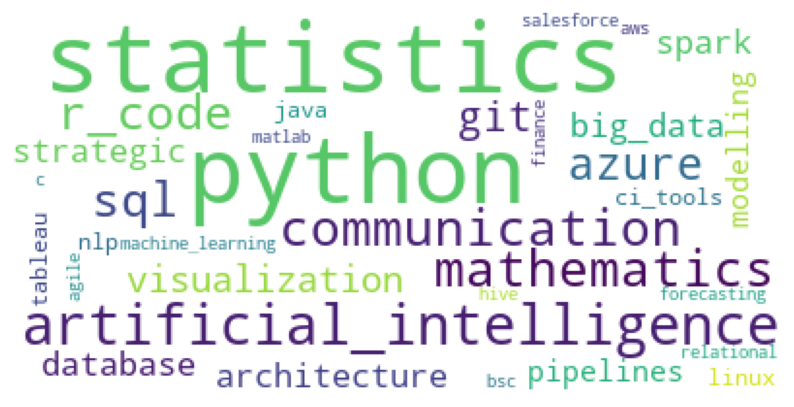

In [14]:
df_fuzzy.fuzzy_match = df_fuzzy.fuzzy_match.apply(replace_all,dic={' ':'_','-':'_'})
fuzzy_list = df_fuzzy['fuzzy_match'].to_list()
fuzzy_wordcloud = WordCloud(
                          background_color="white",
                          max_words=400,
                          max_font_size=50, 
                          min_font_size = 6,
                          collocations=False,
                          random_state=42
                         ).generate(" ".join(fuzzy_list))

fig = plt.figure(1, figsize = (10,7))
plt.imshow(fuzzy_wordcloud)
plt.axis("off")                         
df_new = df_fuzzy[['tokens','fuzzy_match']]
new_fuzzy_list = df_new.set_index('tokens').T.to_dict('records')[0]

In [15]:
#Convert most freq words to dataframe for plotting bar plot

colors = {'python': 'purple',
        'git': 'lightsalmon',
        'r_code': 'blue',
        'sql': 'pink',
        'azure':'darkgreen'}


top_fuzzy = get_top_n_words(fuzzy_list)

## save total as dictionary to add this on
info_total = {'total': None}
info_total['total'] = top_fuzzy

top_fuzzy = pd.DataFrame(top_fuzzy)
top_fuzzy.columns=["Word", "Freq"]
total = top_fuzzy.Freq.sum()
top_fuzzy = top_fuzzy.sort_values(by="Freq",ascending=False)[0:30]
top_fuzzy = top_fuzzy.sort_values(by="Freq",ascending=True) # plotly glitch 
y = top_fuzzy.Word
x = top_fuzzy.Freq/total
fig = go.Figure([go.Bar(x=x, y=y,orientation='h')])

fig.update_layout(
    font=dict(family="Helvetica", size=11, color="black"),
    height=600, width=700,
    template="simple_white",
    margin_b=100, margin_t=100,
    title_text="Top DS skills - fuzzy matching",
    xaxis = dict(tickformat=',.0%')
   )

for k in range(0,len(fig.data)):
    fig["data"][k]["marker"]["color"] = [colors['python'] if c == 'python' 
            else colors['r_code'] if c == 'r_code'
            else colors['sql'] if c == 'sql'
            else colors['git'] if c == 'git'
            else colors['azure'] if c == 'azure'
            else 'lightgrey' for c in fig["data"][k]["y"]]
fig.write_html("../output/top_skills.html")

#fig.show() #TODO fix rendering

#### For each industry 

In [16]:
## for each industry

info = dict.fromkeys(list(data.industry.unique()))

industries = list()
data.industry.fillna("Unknown",inplace=True)

for industry in list(data.industry.unique()):
    _corpus = []
    for row in data[data.industry==industry].clean_words:
        _corpus += row   
    ## TODO bugfix with empty tuple 
    tuples_list_ind = [max([(fuzz.token_set_ratio(i,j),j) for j in skills_list]) for i in _corpus]
    # Unpack list of tuples into two lists
    try:
        similarity_score, fuzzy_match = map(list,zip(*tuples_list_ind))
        # Create pandas DataFrame
        df_ind = pd.DataFrame({"tokens":_corpus, "fuzzy_match": fuzzy_match, "similarity score":similarity_score})
        df_fuzzy_ind = df_ind[df_ind["similarity score"]>=similarity_threshold]
    except:
        print(f"Nothing matched for {industry}")

    if df_fuzzy_ind.size !=0:
        industries.append(industry)
        df_fuzzy_ind.fuzzy_match = df_fuzzy_ind.fuzzy_match.apply(replace_all,dic={' ':'_','-':'_'})

        fuzzy_list_ind = df_fuzzy_ind['fuzzy_match'].to_list()

        top_fuzzy_ind = get_top_n_words(fuzzy_list_ind)
        info[industry] = top_fuzzy_ind    


#### Append total on the info list and save it as pickle file

In [17]:
# Save a dictionary into a pickle file.
pickle.dump(info, open("../output/fuzzy_industries.p", "wb"))  # save it into a file named save.p

### Data Viz fuzzy matching (for each industry)

In [18]:
list_top = data.industry.value_counts(normalize=True).index[1:13]
dict_1 = dict.fromkeys(list_top)


a = [1,2,3]
b = [1,2,3,4]
c = list(itertools.product(a, b))

for count, item in enumerate(dict_1.keys()):
    dict_1[item] = c[count]

fig = make_subplots(
    rows=3, cols=4,
    subplot_titles=(list(dict_1.keys())))

for item in list(dict_1.keys()):
    top_fuzzy = pd.DataFrame(info[item])
    top_fuzzy.columns=["Word", "Freq"]
    total = top_fuzzy.Freq.sum()
    top_fuzzy = top_fuzzy.sort_values(by="Freq",ascending=False)[0:15]
    top_fuzzy = top_fuzzy.sort_values(by="Freq",ascending=True)
    y = top_fuzzy.Word
    x = top_fuzzy.Freq/total
    #fig.add_trace(go.Bar(x=x, y=y,row=1), col=i,row=1)
    fig.add_trace(go.Bar(x=x, y=y,orientation="h",marker_color='grey',name=""),row=dict_1[item][0],col=dict_1[item][1])

fig.update_layout(
    font=dict(family="Helvetica", size=11, color="black"),
    height=1000, width=1500,
    template="simple_white",
    margin_b=100, margin_t=100,
    title_text="Top DS skills per industry - fuzzy matching",
   )

fig.for_each_annotation(lambda a: a.update(font=dict(family="Helvetica", size=12)))
fig.for_each_xaxis(lambda a: a.update(
    dict(showticklabels=True, title="", tickformat=',.0%')))

fig.for_each_yaxis(lambda a: a.update(dict(dtick=1)))

for k in range(0,len(fig.data)):
    fig["data"][k]["marker"]["color"] = [colors['python'] if c == 'python' 
            else colors['r_code'] if c == 'r_code'
            else colors['sql'] if c == 'sql'
            else colors['git'] if c == 'git'
            else colors['azure'] if c == 'azure'
            else 'lightgrey' for c in fig["data"][k]["y"]]
fig.write_html("../output/top_skills_industry.html")

#fig.show()

## More preprocessing

### Extract the fuzzy matched skills

In [19]:
data = data.assign(
    fuzzy_matched_skills=data.apply(
        lambda x: [
            new_fuzzy_list[word]
            for word in x["clean_words"]
            if word in new_fuzzy_list.keys()
        ],
        axis=1,
    )
)

## Word/Sentences count

In [20]:
data["word_count"] = data.word_tokenized.str.len()
# plt.figure(figsize = (7,3))
# sns.histplot(data["word_count"])
# plt.title("Word Count Distribution", size = 12)

## Sentence count 

# obtains sentence count for each indiviual job description
data["sentence_count"] = data.sentence_tokenized.str.len()

# plt.figure(figsize = (7,3))
# sns.histplot(data["sentence_count"])
# plt.title("Sentence Count Distribution", size = 12)

## Stemming & Lemmatization

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemm

In [21]:
# stemmed and lemma words were both examined to choose which method was best suited
data["clean_stemmed"] = data.clean_words.apply(stemming)
data["clean_stemmed_lemmed"] = data.clean_stemmed.apply(lemming)

data.head(1)

,company_name,company_star_rating,role_title,role_location,industry,company_type,listing_desc,listing_url,page_url,page_num,listing_jobDesc_clean,word_tokenized,sentence_tokenized,clean_words,fuzzy_matched_skills,word_count,sentence_count,clean_stemmed,clean_stemmed_lemmed
0,IQVIA CSMS,4.0,Data Analytics Analyst,"London, England",Company - Public (IQV),Biotech & Pharmaceuticals,\r\nResponsible for quality assuring outputs a...,www.glassdoor.com/partner/jobListing.htm?pos=1...,https://www.glassdoor.com/Job/london-data-scie...,1,responsible for quality assuring outputs and i...,"[responsible, for, quality, assuring, outputs,...",[responsible for quality assuring outputs and ...,"[responsible, quality, assuring, outputs, issu...","[communication , sql, salesforce]",268,11,"[respons, qual, ass, output, issu, covid, infe...","[respons, qual, as, output, issu, covid, infec..."


### Create a corpus

In [22]:
COLUMN = "clean_words"

119


(-0.5, 399.5, 199.5, -0.5)

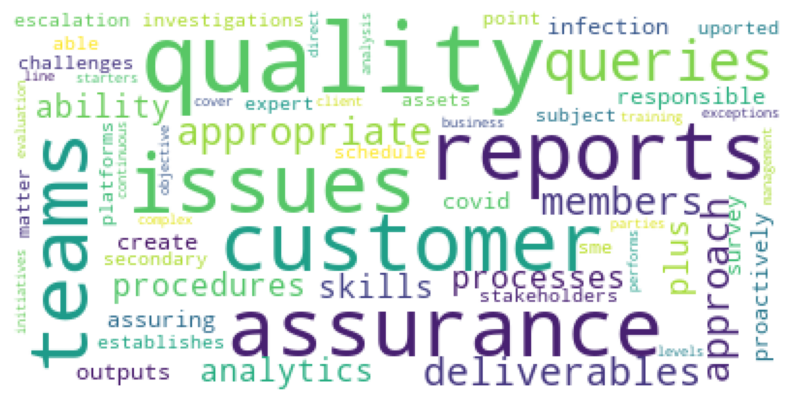

In [23]:
# general corpus & one distinguished with lemmatization applied
# to be used with an additional for loop in the future

word_corpus = list()
for row in data[COLUMN]:
    word_corpus.append(row)

word_corpus = word_corpus[0]
print(len(word_corpus))

## word cloud
stem_wordcloud = WordCloud(
                          background_color="white",
                          max_words=100,
                          max_font_size=50, 
                          min_font_size = 6,
                          random_state=42,
                          collocations=False,
                         ).generate(" ".join(word_corpus))

fig = plt.figure(1, figsize = (10,7))
plt.imshow(stem_wordcloud)
plt.axis("off")

In [24]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(word_corpus)
top_words = pd.DataFrame(top_words)
top_words.columns=["Word", "Freq"]

top_words.head()

,Word,Freq
0,quality,3
1,issues,2
2,assurance,2
3,reports,2
4,customer,2


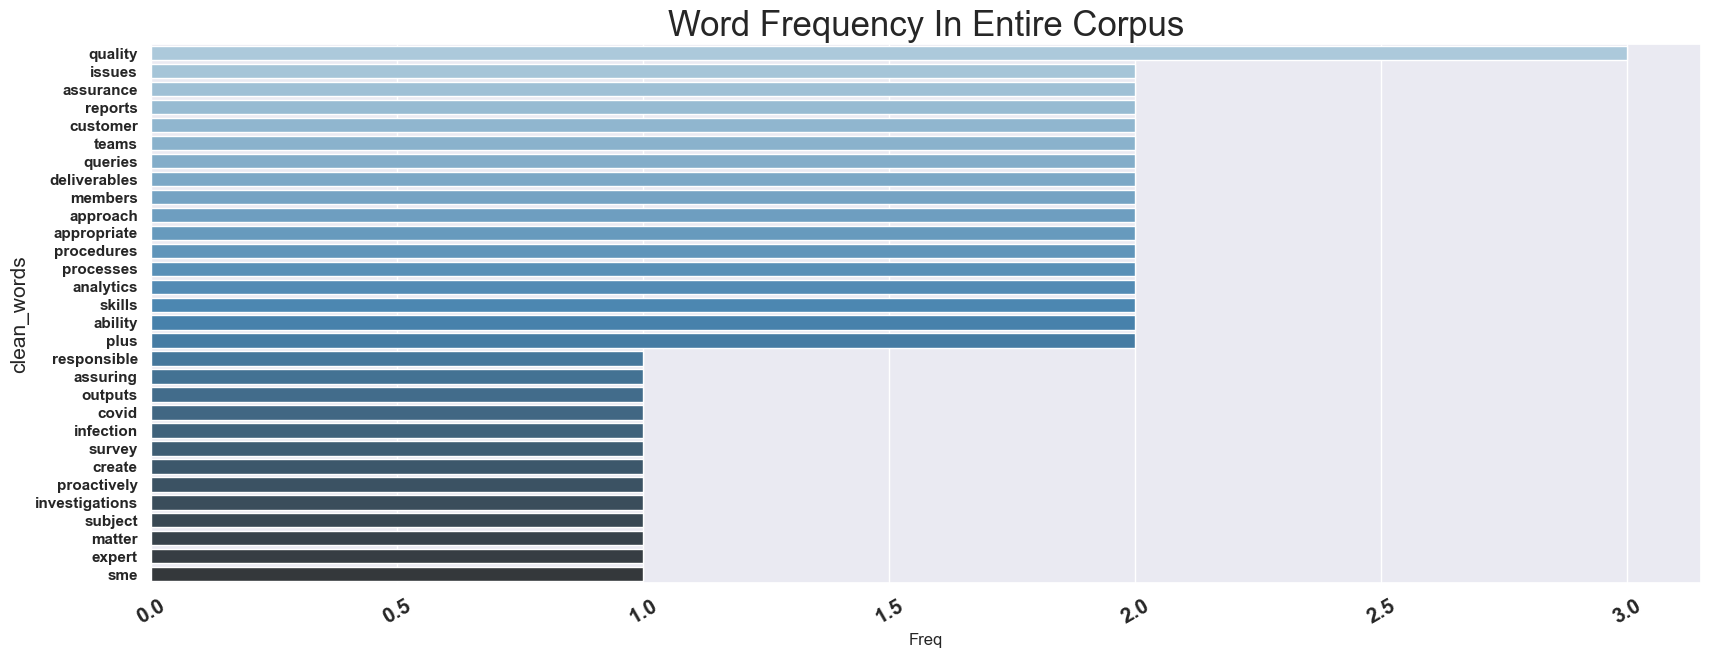

In [25]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={"figure.figsize":(20,7)})
stem_bar = sns.barplot(y="Word", x="Freq", data=top_words[:30], palette="Blues_d")
plt.title("Word Frequency In Entire Corpus", size=25)
plt.ylabel(f"{COLUMN}", size = 15)
stem_bar.set_xticklabels(stem_bar.get_xticklabels(), rotation=30, fontsize = 15);

## N-grams
#### Bigrams

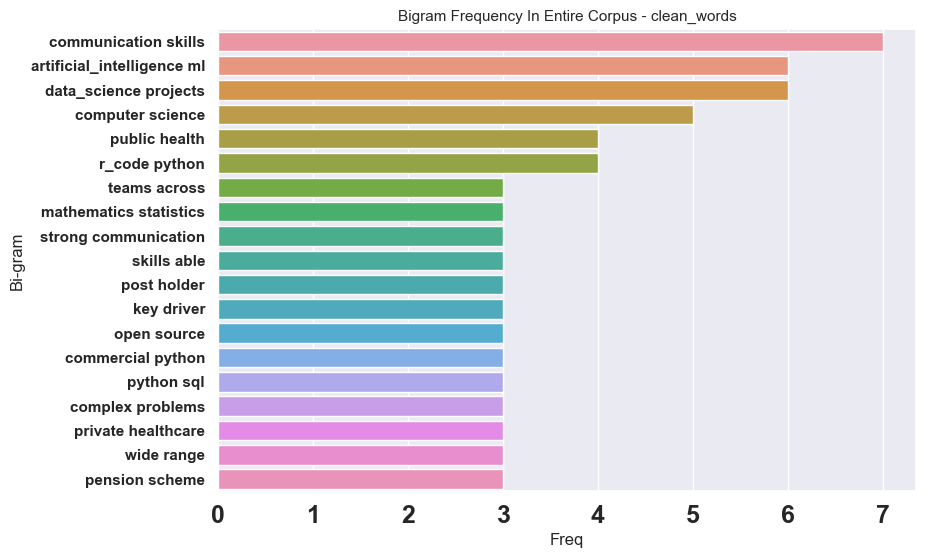

In [26]:
# corpus with stopwords removed and list joined for n-gram distinction
ngram_corpus = data[COLUMN].str.join(" ")
top2_words = get_top_n2_words(ngram_corpus, n = len(ngram_corpus))
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
sns.set(rc={"figure.figsize":(9,6)})
bbar = sns.barplot(y ="Bi-gram", x ="Freq", orient = "h", data = top2_df[:30])
plt.title(f"Bigram Frequency In Entire Corpus - {COLUMN}", size=11)
plt.xticks(size = 18)
bbar.set_yticklabels(bbar.get_yticklabels(), fontsize = 11);
#plt.savefig("bigram_bar.png", dpi=200)

### Trigrams

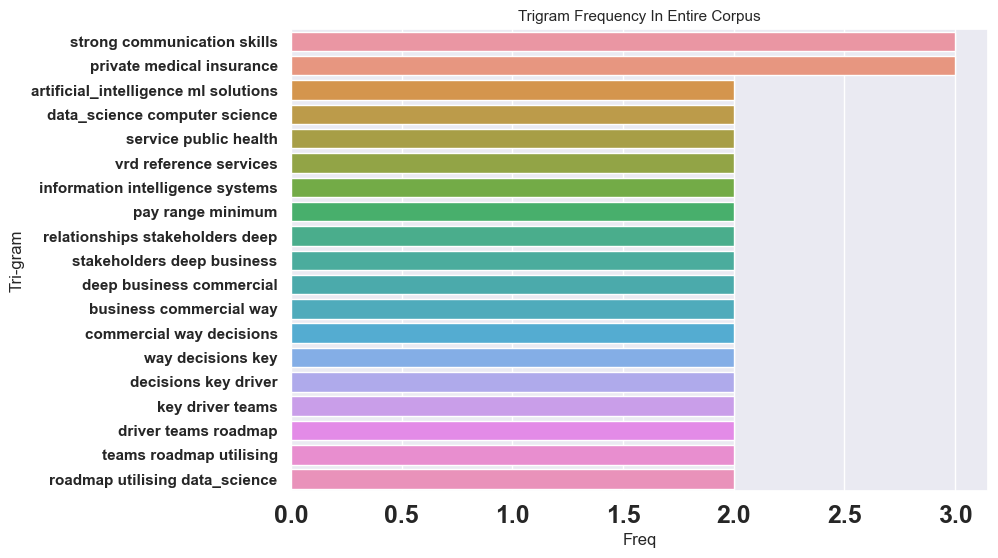

In [27]:
#Most frequently occuring Tri-grams
top3_words = get_top_n3_words(ngram_corpus, n = len(ngram_corpus))
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]
#Barplot of most freq Tri-grams
plt.tight_layout()
sns.set(rc={"figure.figsize":(13,8)})
tbar = sns.barplot(y = "Tri-gram", x = "Freq", orient = "h", data = top3_df[:20])
plt.title("Trigram Frequency In Entire Corpus", size=11)
plt.xticks(size = 18)
tbar.set_yticklabels(tbar.get_yticklabels(), fontsize = 11);
#plt.savefig("trigram_bar.png", dpi=200)

## Traditional matching: Search for specific skills


## can't match enough

2


(-0.5, 399.5, 199.5, -0.5)

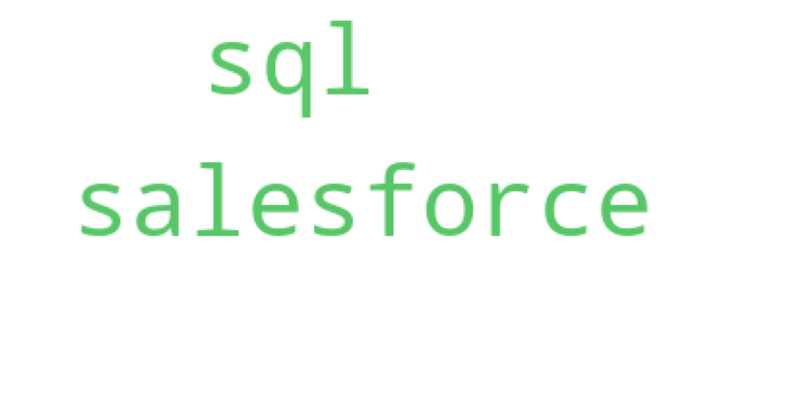

In [28]:
SEL_NOT_NLP = "clean_words"
data_words = data[f"{SEL_NOT_NLP}"]

skills_txt = pd.read_csv("input_data/skills.txt")

data[f"{SEL_NOT_NLP}_skills"] = data_words.apply(search_skills, skills_txt = skills_txt)   

data[f"skills_count"] = data[f"{SEL_NOT_NLP}_skills"].apply(lambda x: len(x))

# general corpus & one distinguished with lemmatization applied
# to be used with an additional for loop in the future
skills_corpus = list()
for row in data[f"{SEL_NOT_NLP}_skills"]:
    skills_corpus.append(row)

skills_corpus = skills_corpus[0]
print(len(skills_corpus))

top_skills = get_top_n_words(skills_corpus)
top_skills = pd.DataFrame(top_skills)
top_skills.columns=["Word", "Freq"]

stem_wordcloud = WordCloud(
                          background_color="white",
                          max_words=100,
                          max_font_size=50, 
                          min_font_size = 6,
                          random_state=42
                         ).generate(" ".join(skills_corpus))

fig = plt.figure(1, figsize = (10,7))
plt.imshow(stem_wordcloud)
plt.axis("off")

## Save the data 

In [29]:
data.to_csv("../output/glassdoor_data_cleaned.csv")